# Capstone 2: Transformations before Exploratory Data Analysis - Walter Piper

# Transformations of physiology signals before exploratory data analysis

## Chest device [all 700Hz]: electrocardiogram (ECG), electromyography (EMG), eletrodermal activity (EDA), temperature (Temp), respiration (Resp), 3-axis accelerometer (ACC: ACC_x, ACC_y, ACC_z)
## Wrist device: 3-axis accelerometer (ACC: ACC_x, ACC_y, ACC_z) [32Hz], blood volume pulse (BVP) [64Hz], electrodermal activity (EDA) [4Hz], temperature (TEMP) [4Hz]

### ECG and BVP requires extraction of inter-beat intervals
### EMG requires extraction of events from changes in frequency and amplitude
### EDA requires extraction of events from changes in average
### Temp and TEMP requires extraction of changes in average
### Resp requires extraction of rising versus falling
### ACC requires extraction of movement (energy?)

# The biosppy package appears to have algorithms for most of these purposes. Documentation at https://biosppy.readthedocs.io/en/latest/biosppy.signals.html and https://biosppy.readthedocs.io/en/stable/

In [1]:
#!pip install biosppy

In [2]:
import numpy as np
from biosppy import signals

In [3]:
signals?

Type:        module
String form: <module 'biosppy.signals' from 'd:\\springboard\\capstone2\\lib\\site-packages\\biosppy\\signals\\__init__.py'>
File:        d:\springboard\capstone2\lib\site-packages\biosppy\signals\__init__.py
Docstring:  
biosppy.signals
---------------

This package provides methods to process common
physiological signals (biosignals):
    * Blood Volume Pulse (BVP)
    * Electrocardiogram (ECG)
    * Electrodermal Activity (EDA)
    * Electroencephalogram (EEG)
    * Electromyogram (EMG)
    * Respiration (Resp)

:copyright: (c) 2015-2018 by Instituto de Telecomunicacoes
:license: BSD 3-clause, see LICENSE for more details.


# Use previously built custom function to load physiology signals from WESAD dataset

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

In [5]:
# Check for data files from all 15 subjects
path = 'D:\\Springboard\\Capstone2\\WESAD\\Capstone2\\data\\raw\\'
#Subjects S1 and S12 had sensor errors and are not included in download
pkl_dict = {'S'+str(i) : glob(path+'S'+str(i)+'\\S'+str(i)+'*.pkl', recursive=True)[0] for i in range(2,18,1) if i != 12} #Signal data

for dictionary, name in zip([pkl_dict], ['signal data']):
    print(name,':')
    for subjectID, pathstring in dictionary.items():
        print(subjectID,': ',pathstring)
    print('\n')

signal data :
S2 :  D:\Springboard\Capstone2\WESAD\Capstone2\data\raw\S2\S2.pkl
S3 :  D:\Springboard\Capstone2\WESAD\Capstone2\data\raw\S3\S3.pkl
S4 :  D:\Springboard\Capstone2\WESAD\Capstone2\data\raw\S4\S4.pkl
S5 :  D:\Springboard\Capstone2\WESAD\Capstone2\data\raw\S5\S5.pkl
S6 :  D:\Springboard\Capstone2\WESAD\Capstone2\data\raw\S6\S6.pkl
S7 :  D:\Springboard\Capstone2\WESAD\Capstone2\data\raw\S7\S7.pkl
S8 :  D:\Springboard\Capstone2\WESAD\Capstone2\data\raw\S8\S8.pkl
S9 :  D:\Springboard\Capstone2\WESAD\Capstone2\data\raw\S9\S9.pkl
S10 :  D:\Springboard\Capstone2\WESAD\Capstone2\data\raw\S10\S10.pkl
S11 :  D:\Springboard\Capstone2\WESAD\Capstone2\data\raw\S11\S11.pkl
S13 :  D:\Springboard\Capstone2\WESAD\Capstone2\data\raw\S13\S13.pkl
S14 :  D:\Springboard\Capstone2\WESAD\Capstone2\data\raw\S14\S14.pkl
S15 :  D:\Springboard\Capstone2\WESAD\Capstone2\data\raw\S15\S15.pkl
S16 :  D:\Springboard\Capstone2\WESAD\Capstone2\data\raw\S16\S16.pkl
S17 :  D:\Springboard\Capstone2\WESAD\Capsto

In [6]:
def check_pkl_raw(Subj_ID, pkl_filepaths, return_data=False):
    """
    Check the integrity of raw time series data for a given subject.
    Input: 
        Subj_ID: string ('S2'-'S17')
        pkl_filepaths: dictionary of paths with Subj_ID as key
        return_data: Boolean. Indicates whether data should be returned at end of function
    Output (if requested by return_data keyword):
        dict_signal_single_subject: Dictionary containing data for the subject Subj_ID. 
    """    
    # LOAD DICTIONARY FROM PKL FILE
    dict_signal_single_subject = pd.read_pickle(pkl_filepaths[Subj_ID]) # Load pickle file
    print('Dictionary from .pkl file has keys:',dict_signal_single_subject.keys())
    # Check type, length of each key's value
    for key in dict_signal_single_subject.keys():
        print(key, ' is type:' , type(dict_signal_single_subject[key]), ' with length:', len(dict_signal_single_subject[key]))
        
    print('\n')
    print('SUBJECT #:',dict_signal_single_subject['subject'])
    
    # LABEL VALUES SHOW TEMPORAL STRUCTURE OF EXPERIMENT
    print('\n')
    print('LABEL unique values:',np.unique(dict_signal_single_subject['label'])) 
    # readme.pdf described label array as labels for the different experimental segments within the research design
    label_dict = {'0':'not defined/transient' ,'1':'baseline' ,'2':'stress' ,'3':'amusement' ,'4':'meditation' ,'5':'ignore' ,'6':'ignore' ,'7':'ignore' }
    print(label_dict)
    plt.plot(np.linspace(0, 6079, len(dict_signal_single_subject['label'])), dict_signal_single_subject['label'])
    plt.title(dict_signal_single_subject['subject']+' label array')
    plt.xlabel('time (s)')
    plt.ylabel('LABEL CODE')
    plt.show()
    
    # EXAMINE PHYSIOLOGY SIGNAL ARRAYS
    print('\n')
    print('SIGNAL KEYS:',dict_signal_single_subject['signal'].keys())
    print('chest:', type(dict_signal_single_subject['signal']['chest']), 'has keys:', dict_signal_single_subject['signal']['chest'].keys()) # Chest = RespiBAN data
    print('wrist:',type(dict_signal_single_subject['signal']['wrist']), 'has keys:', dict_signal_single_subject['signal']['wrist'].keys()) # Wrist = Empatica E4 data
    Wrist_Hz_dict = {'ACC':32, 'BVP':64, 'EDA':4, 'TEMP':4} # Frequency for Wrist device channels
    Chest_Hz_dict = {'ACC':700, 'ECG':700, 'EMG':700, 'EDA':700, 'Temp':700, 'Resp':700} # Frequency for Chest device channels
    # Plot histograms for each recording channel
    for device, device_name, Hz_dict in zip(['chest', 'wrist'], ['Chest (RespiBAN) sensor', 'Wrist (Empatica E4) sensor'], [Chest_Hz_dict, Wrist_Hz_dict]):
        print('\n',device_name)
        fig, axes = plt.subplots(1, len(dict_signal_single_subject['signal'][device].keys()), figsize=[16,2.5])
        for key, ax in zip(dict_signal_single_subject['signal'][device].keys(), axes):
            sig_array = dict_signal_single_subject['signal'][device][key]
            print(key, 'array has shape:', sig_array.shape, 'at',Hz_dict[key], 'Hz for a total of ', sig_array.shape[0]/Hz_dict[key],'seconds')
            sample = np.random.choice(sig_array.flatten(), size=10000)
            ax.hist(sample, bins=20)
            ax.set_title(key)
        fig.suptitle(device_name+'\nHistograms of 10000 randomly sampled datapoints')
        plt.tight_layout()
        plt.show()
    print('\n----------------------------------------------------------------------------\n')
    
    if return_data == True:
        return dict_signal_single_subject

# Load data for one subject, 'S2'

Dictionary from .pkl file has keys: dict_keys(['signal', 'label', 'subject'])
signal  is type: <class 'dict'>  with length: 2
label  is type: <class 'numpy.ndarray'>  with length: 4255300
subject  is type: <class 'str'>  with length: 2


SUBJECT #: S2


LABEL unique values: [0 1 2 3 4 6 7]
{'0': 'not defined/transient', '1': 'baseline', '2': 'stress', '3': 'amusement', '4': 'meditation', '5': 'ignore', '6': 'ignore', '7': 'ignore'}


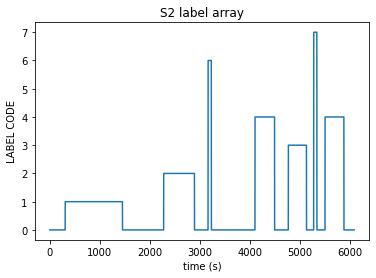



SIGNAL KEYS: dict_keys(['chest', 'wrist'])
chest: <class 'dict'> has keys: dict_keys(['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp'])
wrist: <class 'dict'> has keys: dict_keys(['ACC', 'BVP', 'EDA', 'TEMP'])

 Chest (RespiBAN) sensor
ACC array has shape: (4255300, 3) at 700 Hz for a total of  6079.0 seconds
ECG array has shape: (4255300, 1) at 700 Hz for a total of  6079.0 seconds
EMG array has shape: (4255300, 1) at 700 Hz for a total of  6079.0 seconds
EDA array has shape: (4255300, 1) at 700 Hz for a total of  6079.0 seconds
Temp array has shape: (4255300, 1) at 700 Hz for a total of  6079.0 seconds
Resp array has shape: (4255300, 1) at 700 Hz for a total of  6079.0 seconds


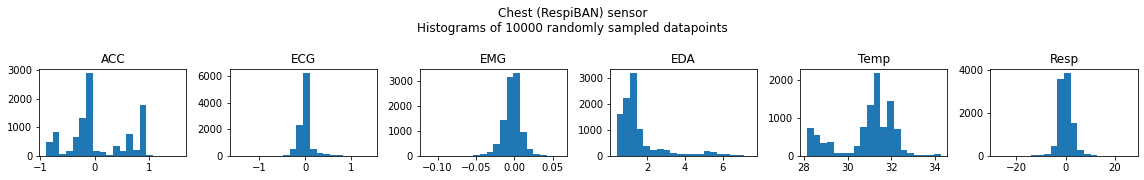


 Wrist (Empatica E4) sensor
ACC array has shape: (194528, 3) at 32 Hz for a total of  6079.0 seconds
BVP array has shape: (389056, 1) at 64 Hz for a total of  6079.0 seconds
EDA array has shape: (24316, 1) at 4 Hz for a total of  6079.0 seconds
TEMP array has shape: (24316, 1) at 4 Hz for a total of  6079.0 seconds


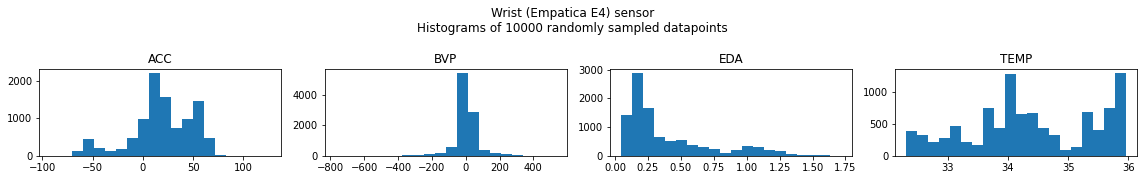


----------------------------------------------------------------------------

<class 'dict'> 3 dict_keys(['signal', 'label', 'subject'])


In [7]:
S2_data = check_pkl_raw('S2', pkl_dict, return_data=True)
print(type(S2_data), len(S2_data), S2_data.keys())

In [8]:
time_index = np.linspace(0,6079, len(S2_data['signal']['chest']['ECG']) )
chest_df = pd.DataFrame({key: list(S2_data['signal']['chest'][key]) for key in ['ECG', 'EMG', 'EDA', 'Temp', 'Resp']}, index=time_index).astype('float')
chest_df = pd.concat([chest_df, pd.DataFrame({ 'ACC_x':list(S2_data['signal']['chest']['ACC'][:,0]), 'ACC_y':list(S2_data['signal']['chest']['ACC'][:,1]), 'ACC_z':list(S2_data['signal']['chest']['ACC'][:,2]) }, index=time_index).astype('float') ], axis=1 )
chest_df = pd.concat([chest_df, pd.Series(list(S2_data['label']), name='label', index=time_index)], axis=1)
display(chest_df.head())

,ECG,EMG,EDA,Temp,Resp,ACC_x,ACC_y,ACC_z,label
0.000000,0.021423,-0.004440,5.250549,30.120758,-1.148987,0.9554,-0.2220,-0.5580,0
0.001429,0.020325,0.004349,5.267334,30.129517,-1.124573,0.9258,-0.2216,-0.5538,0
0.002857,0.016525,0.005173,5.243301,30.138214,-1.152039,0.9082,-0.2196,-0.5392,0
0.004286,0.016708,0.007187,5.249405,30.129517,-1.158142,0.8974,-0.2102,-0.5122,0
0.005714,0.011673,-0.015152,5.286407,30.130951,-1.161194,0.8882,-0.2036,-0.4824,0


<AxesSubplot:>

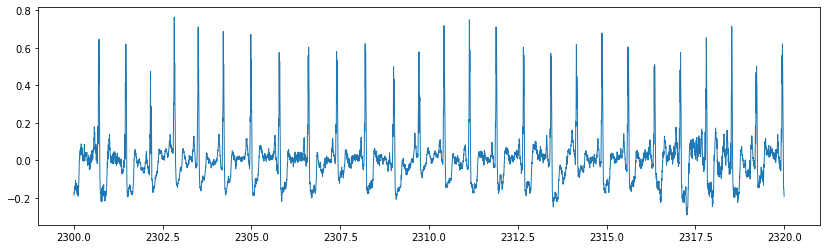

In [9]:
chest_df.loc[(chest_df.index > 2300) & (chest_df.index < 2320)]['ECG'].plot(linewidth=1, figsize=[14,4])

In [10]:
test_ECG_segment = chest_df.loc[(chest_df.index > 2300) & (chest_df.index < 2320)]['ECG']
plt.rcParams['figure.figsize']=[14,4]

<AxesSubplot:>

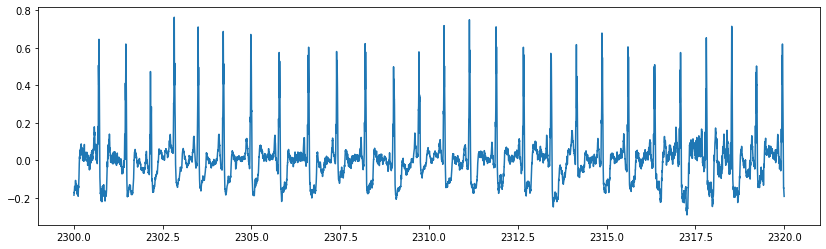

In [11]:
test_ECG_segment.plot()

In [12]:
signals.ecg?

Type:        module
String form: <module 'biosppy.signals.ecg' from 'd:\\springboard\\capstone2\\lib\\site-packages\\biosppy\\signals\\ecg.py'>
File:        d:\springboard\capstone2\lib\site-packages\biosppy\signals\ecg.py
Docstring:  
biosppy.signals.ecg
-------------------

This module provides methods to process Electrocardiographic (ECG) signals.
Implemented code assumes a single-channel Lead I like ECG signal.

:copyright: (c) 2015-2018 by Instituto de Telecomunicacoes
:license: BSD 3-clause, see LICENSE for more details.


In [13]:
signals.ecg.christov_segmenter?

Signature: signals.ecg.christov_segmenter(signal=None, sampling_rate=1000.0)
Docstring:
ECG R-peak segmentation algorithm.

Follows the approach by Christov [Chri04]_.

Parameters
----------
signal : array
    Input filtered ECG signal.
sampling_rate : int, float, optional
    Sampling frequency (Hz).

Returns
-------
rpeaks : array
    R-peak location indices.

References
----------
.. [Chri04] Ivaylo I. Christov, "Real time electrocardiogram QRS
   detection using combined adaptive threshold", BioMedical Engineering
   OnLine 2004, vol. 3:28, 2004
File:      d:\springboard\capstone2\lib\site-packages\biosppy\signals\ecg.py
Type:      function


In [14]:
rpeaks_christov = signals.ecg.christov_segmenter(signal=test_ECG_segment.values, sampling_rate=700)
rpeaks_christov

ReturnTuple(rpeaks=array([  493,  1023,  1977,  2448,  2943,  3486,  4045,  4626,  5177,
        5740,  6300,  6800,  7295,  7795,  8321,  8859,  9399,  9904,
       10408, 10921, 11447, 11957, 12465, 12966, 13455, 13965]))

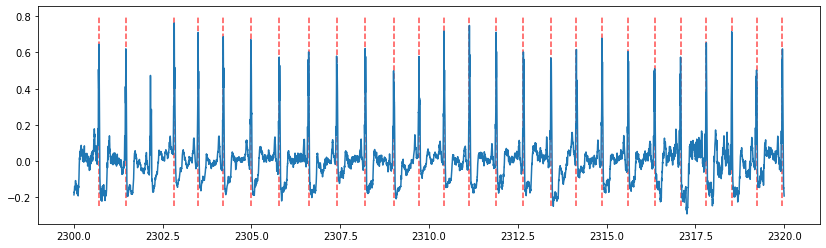

In [15]:
test_ECG_segment.plot()
plt.vlines(test_ECG_segment.iloc[list(rpeaks_christov[0])].index,[-0.25]*len(rpeaks_christov),[0.8]*len(rpeaks_christov), color='r', linestyle='--', alpha=0.7)

##### This christov_segmenter algorithm seems to have missed the 3rd peak.
##### Other algorithms include:
* signals.ecg.engzee_segmenter(signal=None, sampling_rate=1000.0, threshold=0.48)
* signals.ecg.gamboa_segmenter(signal=None, sampling_rate=1000.0, tol=0.002)
* signals.ecg.hamilton_segmenter(signal=None, sampling_rate=1000.0)
* signals.ecg.ssf_segmenter(signal=None, sampling_rate=1000.0, threshold=20, before=0.03, after=0.01)

In [16]:
def plot_ECG_algorithm(df_ECG_segment, algorithm_func, algorithm_name, fs=700):
    rpeaks = algorithm_func(signal=df_ECG_segment.values, sampling_rate=fs)
    df_ECG_segment.plot()
    plt.vlines(df_ECG_segment.iloc[list(rpeaks[0])].index, [-0.25]*len(rpeaks),[0.8]*len(rpeaks), color='r', linestyle='--', alpha=0.7)
    plt.title(algorithm_name)
    plt.xlabel('time(s)')
    plt.ylabel('voltage (mV)')
    plt.show()    

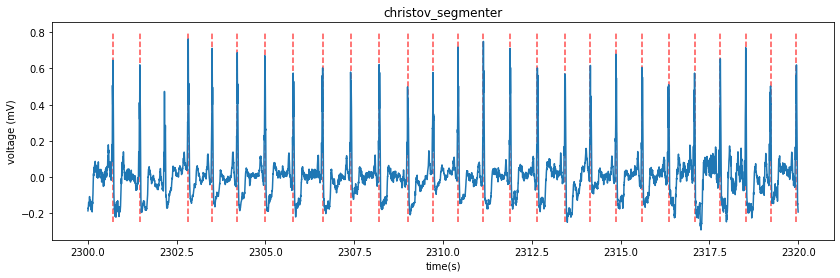

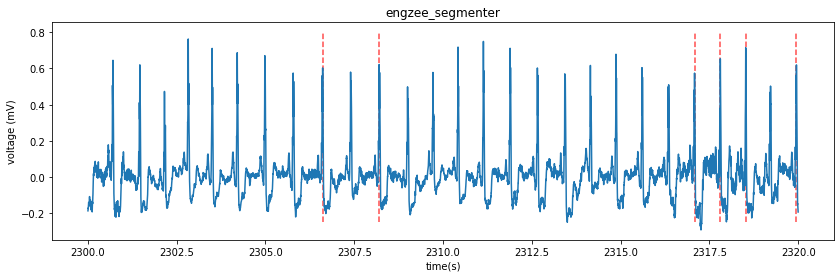

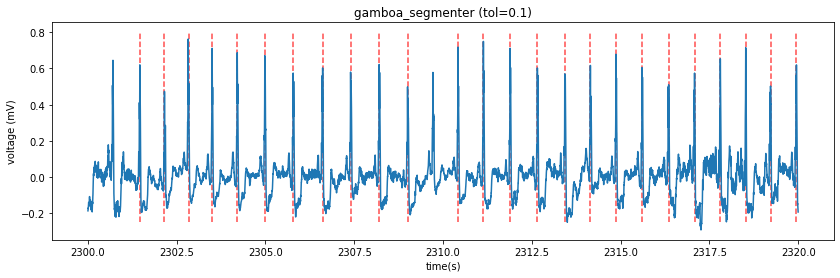

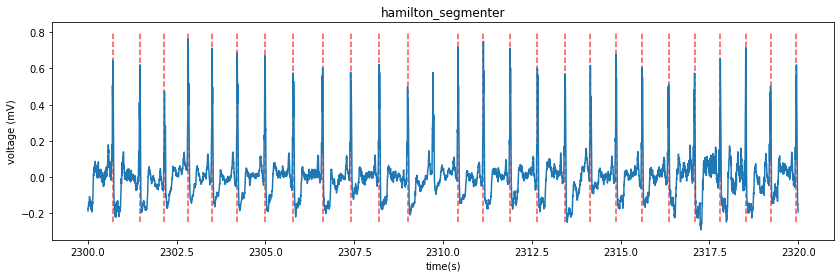

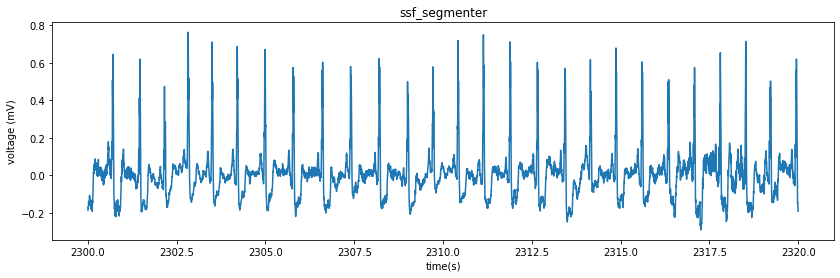

In [17]:
from functools import partial
algo = [signals.ecg.christov_segmenter, signals.ecg.engzee_segmenter, partial(signals.ecg.gamboa_segmenter, tol=0.1), signals.ecg.hamilton_segmenter, signals.ecg.ssf_segmenter]
algo_names = ['christov_segmenter','engzee_segmenter','gamboa_segmenter (tol=0.1)','hamilton_segmenter','ssf_segmenter']
for alg, alg_name in zip(algo, algo_names):
    plot_ECG_algorithm(test_ECG_segment, alg, alg_name)

## No algorithm is perfect. The hamilton segmenter and christov segmenter appear to be best. As shown below, the hamilton segmenter is much more consistent with catching peaks.

In [18]:
from time import time
t = time()
christov = signals.ecg.christov_segmenter(chest_df['ECG'].values, sampling_rate=700)[0]
print('Length of christov-detected array', len(christov))
hamilton = signals.ecg.hamilton_segmenter(chest_df['ECG'].values, sampling_rate=700)[0]
print('Length of hamilton-detected array', len(hamilton))
print('# peaks detected by christov but not hamilton:', len(set(christov)-set(hamilton)))
print('# peaks detected by hamilton but not christov:', len(set(hamilton)-set(christov)))

t2=time()
print('time elapsed (s):',t2-t)

Length of christov-detected array 317
Length of hamilton-detected array 7294
# peaks detected by christov but not hamilton: 11
# peaks detected by hamilton but not christov: 6988
time elapsed (s): 118.45356130599976


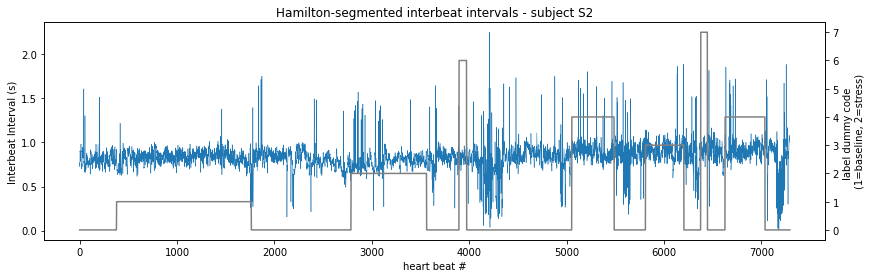

In [19]:
plt.plot((hamilton[1:]-hamilton[:-1])/700, linewidth=0.5)
plt.xlabel('heart beat #')
plt.ylabel('Interbeat Interval (s)')
plt.title('Hamilton-segmented interbeat intervals - subject S2')
plt.twinx()
plt.plot(S2_data['label'][hamilton], color='gray')
plt.ylabel('label dummy code \n(1=baseline, 2=stress)')
plt.show()

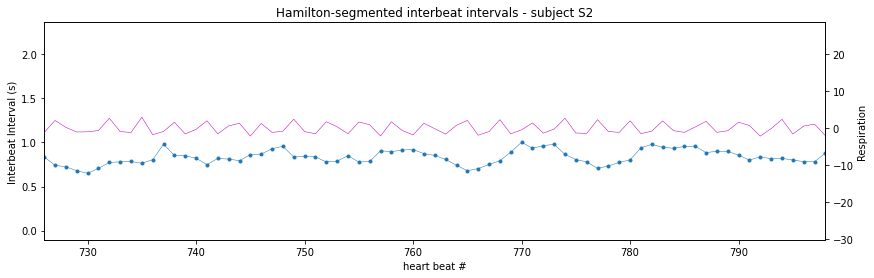

In [20]:
plt.plot((hamilton[1:]-hamilton[:-1])/700, linewidth=0.5, marker='.')
plt.xlabel('heart beat #')
plt.ylabel('Interbeat Interval (s)')
plt.title('Hamilton-segmented interbeat intervals - subject S2')
plt.twinx()
plt.plot(S2_data['signal']['chest']['Resp'][hamilton[1:]], color='m', linewidth=0.5)
plt.ylabel('Respiration')
plt.xlim(726,798)
plt.show()

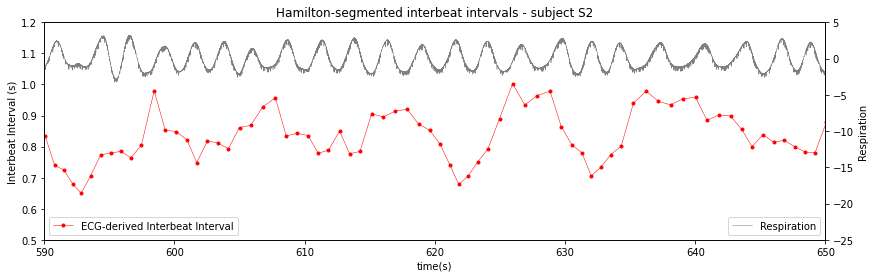

In [21]:
timearray = np.linspace(0, len(S2_data['label'])/700, len(S2_data['label']))
plt.plot(timearray[hamilton[1:]] ,(hamilton[1:]-hamilton[:-1])/700, linewidth=0.5, marker='.', color='r', label='ECG-derived Interbeat Interval')
plt.xlabel('time(s)')
plt.ylabel('Interbeat Interval (s)')
plt.title('Hamilton-segmented interbeat intervals - subject S2')
plt.ylim(0.5, 1.2)
plt.legend(loc='lower left')
plt.twinx()
plt.plot(timearray, S2_data['signal']['chest']['Resp'], color='gray', linewidth=0.5, label='Respiration')
plt.ylabel('Respiration')
plt.xlim(590,650)
plt.ylim(-25, 5)
plt.legend(loc='lower right')
plt.show()

# <span style="color:blue">  Create widget to allow user input to correct misplaced heart beat times.  </blue>
Starting with tutorial from https://ipywidgets.readthedocs.io/en/stable/examples/Widget%20Basics.html#

In [22]:
import ipywidgets as widgets

In [23]:
widgets.IntSlider()

IntSlider(value=0)

In [24]:
widgets.IntSlider?

Init signature: widgets.IntSlider(*args, **kwargs)
Docstring:     
Slider widget that represents an integer bounded from above and below.
    
Init docstring:
Parameters
----------
value: integer
    The initial value.
min: integer
    The lower limit for the value.
max: integer
    The upper limit for the value.
step: integer
    The step between allowed values.
File:           d:\springboard\capstone2\lib\site-packages\ipywidgets\widgets\widget_int.py
Type:           MetaHasTraits
Subclasses:     


In [25]:
from IPython.display import display
w = widgets.IntSlider()
display(w)

IntSlider(value=0)

In [26]:
w.value

0

In [27]:
w.keys

['_dom_classes',
 '_model_module',
 '_model_module_version',
 '_model_name',
 '_view_count',
 '_view_module',
 '_view_module_version',
 '_view_name',
 'continuous_update',
 'description',
 'description_tooltip',
 'disabled',
 'layout',
 'max',
 'min',
 'orientation',
 'readout',
 'readout_format',
 'step',
 'style',
 'value']

In [28]:
a = widgets.IntText()
b = widgets.IntSlider(max=100)
display(a,b)

mylink = widgets.jslink((a, 'value'), (b, 'value'))

IntText(value=0)

IntSlider(value=0)

In [29]:
mylink.unlink()

In [30]:
action_buttons = widgets.ToggleButtons(options=['Add new point before', 'Move selected', 'Delete selected'])
display(action_buttons)

ToggleButtons(options=('Add new point before', 'Move selected', 'Delete selected'), value='Add new point befor…

In [31]:
add_button = widgets.Button(description='Add new point before')
move_button = widgets.Button(description='Move selected')
del_button = widgets.Button(description='Delete selected')
undo_button = widgets.Button(description='Undo')
redo_button = widgets.Button(description='Redo')
prev_button = widgets.Button(description='Previous')
next_button = widgets.Button(description='Next')
display(add_button, move_button, del_button)
display(undo_button, redo_button, prev_button, next_button)

Button(description='Add new point before', style=ButtonStyle())

Button(description='Move selected', style=ButtonStyle())

Button(description='Delete selected', style=ButtonStyle())

Button(description='Undo', style=ButtonStyle())

Button(description='Redo', style=ButtonStyle())

Button(description='Previous', style=ButtonStyle())

Button(description='Next', style=ButtonStyle())

In [32]:
jonesing = partial(print, 'ooga booga')

In [33]:
jonesing()

ooga booga


In [34]:
test_button = widgets.Button(description='print that string')
display(test_button)
test_button.on_click(jonesing)

Button(description='print that string', style=ButtonStyle())

In [35]:
widgets.interactive?

Init signature: widgets.interactive(*args, **kwargs)
Docstring:     
A VBox container containing a group of interactive widgets tied to a
function.

Parameters
----------
__interact_f : function
    The function to which the interactive widgets are tied. The `**kwargs`
    should match the function signature.
__options : dict
    A dict of options. Currently, the only supported keys are
    ``"manual"`` and ``"manual_name"``.
**kwargs : various, optional
    An interactive widget is created for each keyword argument that is a
    valid widget abbreviation.

Note that the first two parameters intentionally start with a double
underscore to avoid being mixed up with keyword arguments passed by
``**kwargs``.
Init docstring: Public constructor
File:           d:\springboard\capstone2\lib\site-packages\ipywidgets\widgets\interaction.py
Type:           MetaHasTraits
Subclasses:     


In [36]:
%matplotlib widget

x = np.linspace(0, 2 * np.pi)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
line, = ax.plot(x, np.sin(x))

def update(w = 1.0):
    line.set_ydata(np.sin(w * x))
    fig.canvas.draw()

widgets.interact(update);

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(FloatSlider(value=1.0, description='w', max=3.0, min=-1.0), Output()), _dom_classes=('wi…

In [40]:
u = widgets.IntSlider(min=1, max=5)
display(u)

IntSlider(value=1, max=5, min=1)

In [41]:
u.value

1

In [42]:
%matplotlib widget

x = np.linspace(0, 2 * np.pi)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
line, = ax.plot(x, np.sin(x))

def update(w = 1.0):
    line.set_ydata(np.sin(u.value * w * x))
    fig.canvas.draw()

widgets.interact(update);

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(FloatSlider(value=1.0, description='w', max=3.0, min=-1.0), Output()), _dom_classes=('wi…

In [43]:
display(u)

IntSlider(value=5, max=5, min=1)

In [65]:
%matplotlib widget


x = np.linspace(0, 2 * np.pi)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
line, = ax.plot(x, np.sin(x))
v=1
line2 = ax.axvline(v)

def update(v = 1.0):
    line.set_ydata(np.sin(x))
    line2.set_xdata(v)
    fig.canvas.draw()
    global ref
    ref = v

widgets.interact(update);

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(FloatSlider(value=1.0, description='v', max=3.0, min=-1.0), Output()), _dom_classes=('wi…

In [68]:
ref

1.8

In [69]:
widgets.interact?

Signature:      widgets.interact(_InteractFactory__interact_f=None, **kwargs)
Type:           _InteractFactory
String form:    <ipywidgets.widgets.interaction._InteractFactory object at 0x000001F7C3D76A90>
File:           d:\springboard\capstone2\lib\site-packages\ipywidgets\widgets\interaction.py
Docstring:     
Factory for instances of :class:`interactive`.

This class is needed to support options like::

    >>> @interact.options(manual=True)
    ... def greeting(text="World"):
    ...     print("Hello {}".format(text))

Parameters
----------
cls : class
    The subclass of :class:`interactive` to construct.
options : dict
    A dict of options used to construct the interactive
    function. By default, this is returned by
    ``cls.default_options()``.
kwargs : dict
    A dict of **kwargs to use for widgets.
Call docstring:
Make the given function interactive by adding and displaying
the corresponding :class:`interactive` widget.

Expects the first argument to be a function. Parame

In [156]:
s_t = 590
e_t = 595

timearray = np.linspace(0, len(S2_data['label'])/700, len(S2_data['label']))
s_idx = np.argmin(abs(timearray[hamilton[1:]]-s_t))
e_idx = np.argmin(abs(timearray[hamilton[1:]]-e_t))

ax2_s_idx = np.argmin(abs(timearray-s_t))
ax2_e_idx = np.argmin(abs(timearray-e_t))

fig, (ax, ax2) = plt.subplots(2,1, sharex=True)
ax.plot(timearray[hamilton[1:]][s_idx:e_idx] ,(hamilton[1:]-hamilton[:-1])[s_idx:e_idx]/700, linewidth=0.5, marker='.', color='r', label='ECG-derived Interbeat Interval')
ax.set_xlabel('time(s)')
ax.set_ylabel('Interbeat Interval (s)')
ax.set_title('Hamilton-segmented interbeat intervals - subject S2')
ax.set_ylim(0.5, 1.2)
ax.legend(loc='lower right')
ax2.plot(timearray[ax2_s_idx:ax2_e_idx], S2_data['signal']['chest']['ECG'][ax2_s_idx:ax2_e_idx], color='gray', linewidth=0.5, label='Raw ECG')
ax2.set_ylabel('Respiration')
#ax2.set_xlim(590,650)
ax2.legend(loc='lower right')
#plt.show()

v=(ax.get_xlim()[1]+ax.get_xlim()[0])/2
line = ax.axvline(v, alpha=0.8)
line2 = ax2.axvline(v, alpha=0.8)

def update(v = 1.0):
    line.set_xdata(v)
    line2.set_xdata(v)
    fig.canvas.draw()
    global ref
    ref = v

widgets.interact(update, v=widgets.FloatSlider(min=ax.get_xlim()[0], max=ax.get_xlim()[1], step=(ax.get_xlim()[1]-ax.get_xlim()[0])/100, value=(ax.get_xlim()[1]+ax.get_xlim()[0])/2));

log_button = widgets.Button(description='Record value')
the_log = []

log_button.on_click(lambda val: the_log.append(ref))
display(log_button)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(FloatSlider(value=592.4994249522772, description='v', max=595.2486398840599, min=589.750…

Button(description='Record value', style=ButtonStyle())

In [159]:
the_log

[593.37917]

In [155]:
plt.clf()

In [174]:
line.get_ydata()

[0, 1]

In [165]:
fl_sl = widgets.FloatRangeSlider()

In [166]:
fl_sl.keys

['_dom_classes',
 '_model_module',
 '_model_module_version',
 '_model_name',
 '_view_count',
 '_view_module',
 '_view_module_version',
 '_view_name',
 'continuous_update',
 'description',
 'description_tooltip',
 'disabled',
 'layout',
 'max',
 'min',
 'orientation',
 'readout',
 'readout_format',
 'step',
 'style',
 'value']

In [171]:
fl_sl.value

(39.8, 84.1)

In [172]:
fl_sl.value[0]

39.8

In [173]:
fl_sl.value[1]

84.1

In [170]:
display(fl_sl)

FloatRangeSlider(value=(25.0, 75.0))

In [318]:
fig, ax = plt.subplots(1,1)

def get_plot_params(s_t=20, e_t=40):
    #s_t = 20
    #e_t = 40
    timearray = np.linspace(0, len(S2_data['label'])/700, len(S2_data['label']))
    s_idx = np.argmin(abs(timearray[hamilton]-s_t))
    e_idx = np.argmin(abs(timearray[hamilton]-e_t))

    ax2_s_idx = np.argmin(abs(timearray-s_t))
    ax2_e_idx = np.argmin(abs(timearray-e_t))

    Xt_for_IBI_array = timearray[hamilton[1:]][s_idx:e_idx]
    IBI_array = (hamilton[1:]-hamilton[:-1])[s_idx:e_idx]/700

    Xt_for_ECG_array = timearray[ax2_s_idx:ax2_e_idx]
    ECG_array = S2_data['signal']['chest']['ECG'][ax2_s_idx:ax2_e_idx]

    length_IBI = len(IBI_array)
    return (Xt_for_IBI_array, IBI_array, Xt_for_ECG_array, ECG_array, length_IBI)

Xt_for_IBI_array, IBI_array, Xt_for_ECG_array, ECG_array, length_IBI = get_plot_params()

plot1 = ax.plot(Xt_for_IBI_array, IBI_array, linewidth=0.5, marker='.', color='r', label='ECG-derived Interbeat Interval')
plot2 = ax.plot(Xt_for_ECG_array, ECG_array, color='k', linewidth=0.5, label='Raw ECG')
ylims = ax.get_ylim()
plot3 = ax.vlines(x=Xt_for_IBI_array, ymin=[ylims[0]]*length_IBI, ymax=[ylims[1]]*length_IBI, color='b', linestyle='--', alpha=0.3)

left_line = ax.axvline(ax.get_xlim()[0], color='y')
right_line = ax.axvline(ax.get_xlim()[0], color='y')
#fill_in = ax.fill_betweenx(left_line.get_xdata(), right_line.get_xdata())


def select_range(the_range):
    left_line.set_xdata(the_range[0])
    right_line.set_xdata(the_range[1])
    fig.canvas.draw()
    global s_range
    global e_range
    s_range = the_range[0]
    e_range = the_range[1]
    
def zoom_range(selected_range=[s_range, e_range]):
    with output:
        Xt_for_IBI_array, IBI_array, Xt_for_ECG_array, ECG_array, length_IBI = get_plot_params(s_t=selected_range[0], e_t=selected_range[1])
        plot1[0].set_xdata(Xt_for_IBI_array)
        plot1[0].set_ydata(IBI_array)
        plot2[0].set_xdata(Xt_for_ECG_array)
        plot2[0].set_ydata(ECG_array)

        masked_verts = np.ma.empty((len(Xt_for_IBI_array), 2, 2))
        masked_verts[:, 0, 0] = Xt_for_IBI_array
        masked_verts[:, 0, 1] = ax.get_ylim()[0]
        masked_verts[:, 1, 0] = Xt_for_IBI_array
        masked_verts[:, 1, 1] = ax.get_ylim()[1]

        plot3.set_segments(masked_verts)

        fig.canvas.draw()
        top_layer = widgets.interact(select_range, the_range=widgets.FloatRangeSlider(min=ax.get_xlim()[0], max=ax.get_xlim()[1], value=(ax.get_xlim()[0], ax.get_xlim()[0]+1)))
        display(top_layer)

left_line, right_line = set_up_plot(ax)
top_layer = widgets.interact(select_range, the_range=widgets.FloatRangeSlider(min=ax.get_xlim()[0], max=ax.get_xlim()[1], value=(ax.get_xlim()[0], ax.get_xlim()[0]+1)))
display(top_layer)

zoom_button = widgets.Button(description='Zoom')
output = widgets.Output()
display(zoom_button, output)
zoom_button.on_click(zoom_range)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(FloatRangeSlider(value=(17.939754215861214, 18.939754215861214), description='the_range'…

<function __main__.select_range(the_range)>

Button(description='Zoom', style=ButtonStyle())

Output()

In [317]:
button = widgets.Button(description="Click Me!")
output = widgets.Output()

display(button, output)

def on_button_clicked(b):
    with output:
        print("Button clicked.")

button.on_click(on_button_clicked)

Button(description='Click Me!', style=ButtonStyle())

Output()

In [267]:
widgets.Button.on_click?

Signature: widgets.Button.on_click(self, callback, remove=False)
Docstring:
Register a callback to execute when the button is clicked.

The callback will be called with one argument, the clicked button
widget instance.

Parameters
----------
remove: bool (optional)
    Set to true to remove the callback from the list of callbacks.
File:      d:\springboard\capstone2\lib\site-packages\ipywidgets\widgets\widget_button.py
Type:      function


In [282]:
s_range

35.095

In [283]:
e_range

38.095

In [296]:
plot1

In [ ]:
fig, ax = plt.subplots(1,1)

def get_plot_params(s_t=20, e_t=40):
    #s_t = 20
    #e_t = 40
    timearray = np.linspace(0, len(S2_data['label'])/700, len(S2_data['label']))
    s_idx = np.argmin(abs(timearray[hamilton]-s_t))
    e_idx = np.argmin(abs(timearray[hamilton]-e_t))

    ax2_s_idx = np.argmin(abs(timearray-s_t))
    ax2_e_idx = np.argmin(abs(timearray-e_t))

    Xt_for_IBI_array = timearray[hamilton[1:]][s_idx:e_idx]
    IBI_array = (hamilton[1:]-hamilton[:-1])[s_idx:e_idx]/700

    Xt_for_ECG_array = timearray[ax2_s_idx:ax2_e_idx]
    ECG_array = S2_data['signal']['chest']['ECG'][ax2_s_idx:ax2_e_idx]

    length_IBI = len(IBI_array)
    return (Xt_for_IBI_array, IBI_array, Xt_for_ECG_array, ECG_array, length_IBI)

Xt_for_IBI_array, IBI_array, Xt_for_ECG_array, ECG_array, length_IBI = get_plot_params()

plot1 = ax.plot(Xt_for_IBI_array, IBI_array, linewidth=0.5, marker='.', color='r', label='ECG-derived Interbeat Interval')
plot2 = ax.plot(Xt_for_ECG_array, ECG_array, color='k', linewidth=0.5, label='Raw ECG')
ylims = ax.get_ylim()
plot3 = ax.vlines(x=Xt_for_IBI_array, ymin=[ylims[0]]*length_IBI, ymax=[ylims[1]]*length_IBI, color='b', linestyle='--', alpha=0.3)

left_line = ax.axvline(ax.get_xlim()[0], color='y')
right_line = ax.axvline(ax.get_xlim()[0], color='y')
#fill_in = ax.fill_betweenx(left_line.get_xdata(), right_line.get_xdata())


def select_range(the_range):
    left_line.set_xdata(the_range[0])
    right_line.set_xdata(the_range[1])
    fig.canvas.draw()
    global s_range
    global e_range
    s_range = the_range[0]
    e_range = the_range[1]
    
def zoom_range(selected_range=[s_range, e_range]):
    with output:
        Xt_for_IBI_array, IBI_array, Xt_for_ECG_array, ECG_array, length_IBI = get_plot_params(s_t=selected_range[0], e_t=selected_range[1])
        plot1[0].set_xdata(Xt_for_IBI_array)
        plot1[0].set_ydata(IBI_array)
        plot2[0].set_xdata(Xt_for_ECG_array)
        plot2[0].set_ydata(ECG_array)

        masked_verts = np.ma.empty((len(Xt_for_IBI_array), 2, 2))
        masked_verts[:, 0, 0] = Xt_for_IBI_array
        masked_verts[:, 0, 1] = ax.get_ylim()[0]
        masked_verts[:, 1, 0] = Xt_for_IBI_array
        masked_verts[:, 1, 1] = ax.get_ylim()[1]

        plot3.set_segments(masked_verts)

        fig.canvas.draw()
        top_layer = widgets.interact(select_range, the_range=widgets.FloatRangeSlider(min=ax.get_xlim()[0], max=ax.get_xlim()[1], value=(ax.get_xlim()[0], ax.get_xlim()[0]+1)))
        display(top_layer)

left_line, right_line = set_up_plot(ax)
top_layer = widgets.interact(select_range, the_range=widgets.FloatRangeSlider(min=ax.get_xlim()[0], max=ax.get_xlim()[1], value=(ax.get_xlim()[0], ax.get_xlim()[0]+1)))
display(top_layer)

zoom_button = widgets.Button(description='Zoom')
output = widgets.Output()
display(zoom_button, output)
zoom_button.on_click(zoom_range)